In [8]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.utils import to_categorical


In [9]:
# Data Loading and Preprocessing
try:
    data = pd.read_csv('ckextended.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: not found.")
    data = pd.DataFrame({
        'emotion': np.random.randint(0, 8, 1000),
        'pixels': [' '.join(map(str, np.random.randint(0, 256, 48*48))) for _ in range(1000)]
    })
    print("Using dummy data")

if 'Usage' in data.columns:
    data.drop(columns=['Usage'], axis=1, inplace=True)

def process_pixels(pixels_series):
    images = []
    for pixel_seq in pixels_series:
        pixel_vals = np.array([int(p) for p in pixel_seq.split()], dtype='float32')
        image = pixel_vals.reshape(48, 48, 1) / 255.0
        images.append(image)
    return np.array(images)

x_data = process_pixels(data['pixels'])
y_data = data['emotion'].values
y_cat = to_categorical(y_data, num_classes=8)
class_names = sorted(data['emotion'].unique())

print(f"Data processed. Shapes: x_data={x_data.shape}, y_data={y_data.shape}")

Dataset loaded successfully.
Data processed. Shapes: x_data=(920, 48, 48, 1), y_data=(920,)


In [10]:
# Split the Data
x_train, x_test, y_train_cat, y_test_cat, y_train_labels, y_test_labels = train_test_split(
    x_data, y_cat, y_data, test_size=0.2, random_state=42, stratify=y_data
)
print("Data split into training and testing sets.")

Data split into training and testing sets.


In [11]:
# Define and Train the CNN Feature Extractor
cnn_model = Sequential([
    Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu', name='feature_layer'),
    Dropout(0.5),
    Dense(8, activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.build(input_shape=(None, 48, 48, 1))

print("compiled.")
cnn_model.summary() 

print("\nTraining starts...")
history = cnn_model.fit(
    x_train, y_train_cat,
    batch_size=64,
    epochs=100,
    validation_data=(x_test, y_test_cat),
    verbose=1
)
print("CNN training complete.")

compiled.


c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_layer (Dense)           │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 895,112 (3.41 MB)

 Trainable params: 895,112 (3.41 MB)

 Non-trainable params: 0 (0.00 B)


Training starts...
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.5322 - loss: 1.6616 - val_accuracy: 0.6467 - val_loss: 1.5953
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.6366 - loss: 1.3943 - val_accuracy: 0.6467 - val_loss: 1.6316
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.6454 - loss: 1.3908 - val_accuracy: 0.6467 - val_loss: 1.4762
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.6516 - loss: 1.3377 - val_accuracy: 0.6467 - val_loss: 1.5071
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.6680 - loss: 1.3257 - val_accuracy: 0.6467 - val_loss: 1.5855
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.6742 - loss: 1.3592 - val_accuracy: 0.6467 - val_loss: 1.5204
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.6567 - loss: 1.3628 - val_accuracy: 0.6467 - val_loss: 1.4342
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.6552 - los

In [12]:
#Extract Features from the CNN
feature_extractor = Model(
    inputs=cnn_model.layers[0].input,
    outputs=cnn_model.get_layer('feature_layer').output
)
x_train_feat = feature_extractor.predict(x_train)
x_test_feat = feature_extractor.predict(x_test)
print(f"Feature extraction complete. Shapes: x_train_feat={x_train_feat.shape}, x_test_feat={x_test_feat.shape}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Feature extraction complete. Shapes: x_train_feat=(736, 128), x_test_feat=(184, 128)


In [13]:
#Train and Compare Classifiers (AdaBoost and SVM)

#AdaBoost
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(x_train_feat, y_train_labels)
y_pred_ada = ada.predict(x_test_feat)
accuracy_ada = accuracy_score(y_test_labels, y_pred_ada)

#SVM
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(x_train_feat, y_train_labels)
y_pred_svm = svm.predict(x_test_feat)
accuracy_svm = accuracy_score(y_test_labels, y_pred_svm)

print(f"AdaBoost Accuracy on CNN features: {accuracy_ada:.4f}")
print(f"SVM Accuracy on CNN features:      {accuracy_svm:.4f}")

AdaBoost Accuracy on CNN features: 0.8641
SVM Accuracy on CNN features:      0.9348


In [14]:
#Initialize SHAP for AdaBoost
print("\nStarting SHAP Analysis for AdaBoost")
shap.initjs()
background_data = shap.kmeans(x_train_feat, 100)
explainer_ada = shap.KernelExplainer(ada.predict_proba, background_data)
shap_values_ada = explainer_ada.shap_values(x_test_feat)
print("AdaBoost SHAP values calculated.")


Starting SHAP Analysis for AdaBoost


100%|██████████| 184/184 [13:58<00:00,  4.56s/it]

AdaBoost SHAP values calculated.



AdaBoost: Global Feature Importance Plot


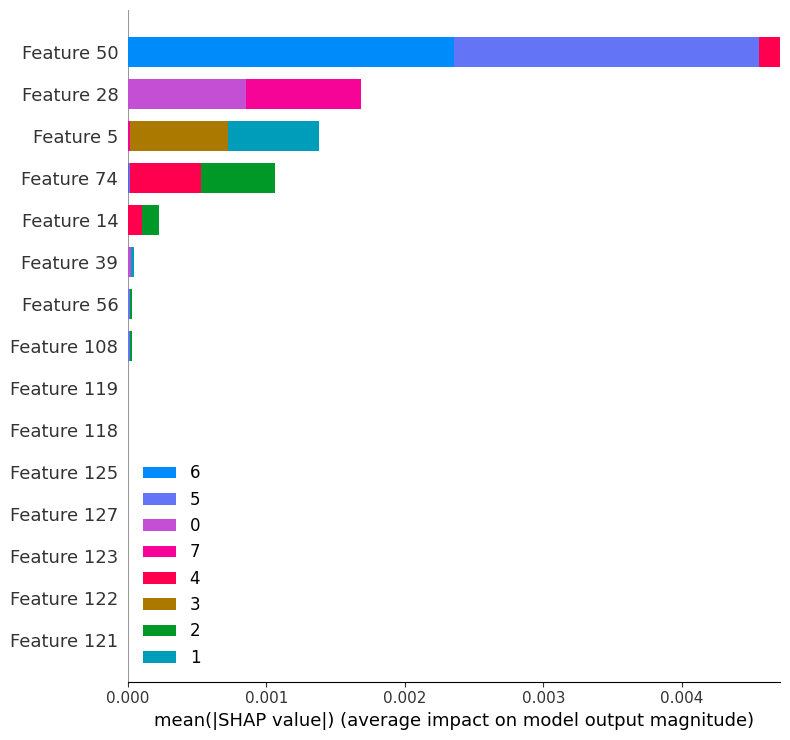

In [15]:
#AdaBoost : Global Feature Importance (Bar Plot)
print("\nAdaBoost: Global Feature Importance Plot")
shap.summary_plot(
    shap_values_ada,
    features=x_test_feat,
    plot_type="bar",
    class_names=class_names,
    max_display=15,
    show=True
)


--- AdaBoost: Local Explanation for a Single Prediction ---
Explaining Instance 0:
  - True Emotion: 6 (6)
  - Predicted Emotion: 6 (6)


c:\Python312\Lib\site-packages\shap\plots\_force_matplotlib.py:107: RuntimeWarning: divide by zero encountered in scalar divide
  feature_contribution = np.abs(float(feature[0]) - pre_val) / np.abs(total_effect)


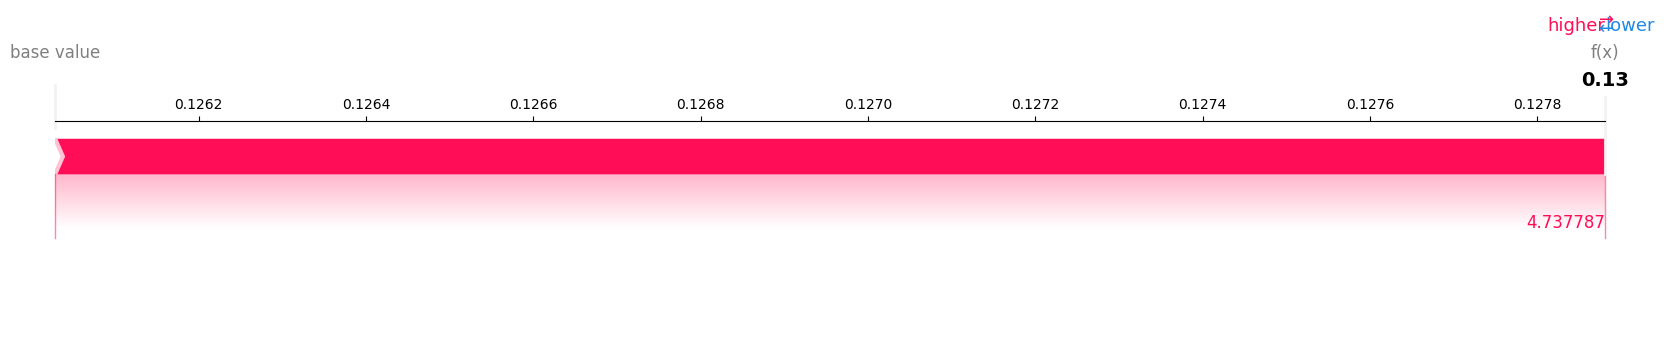

In [ ]:
#AdaBoost - Local Explanation (Force Plot)
print("\nAdaBoost: Local Explanation for a Single Prediction")
instance_index = 0
true_label = y_test_labels[instance_index]
predicted_label_val = ada.predict(x_test_feat[instance_index:instance_index+1])[0]

print(f"Explaining Instance {instance_index}:")
print(f"  - True Emotion: {true_label} ({class_names[true_label]})")
print(f"  - Predicted Emotion: {predicted_label_val} ({class_names[predicted_label_val]})")

shap_values_for_plot = shap_values_ada[instance_index, :, true_label]

shap.force_plot(
    explainer_ada.expected_value[true_label],
    shap_values_for_plot, 
    x_test_feat[instance_index, :],
    matplotlib=True,
    show=True
)


AdaBoost: Beeswarm Summary Plot


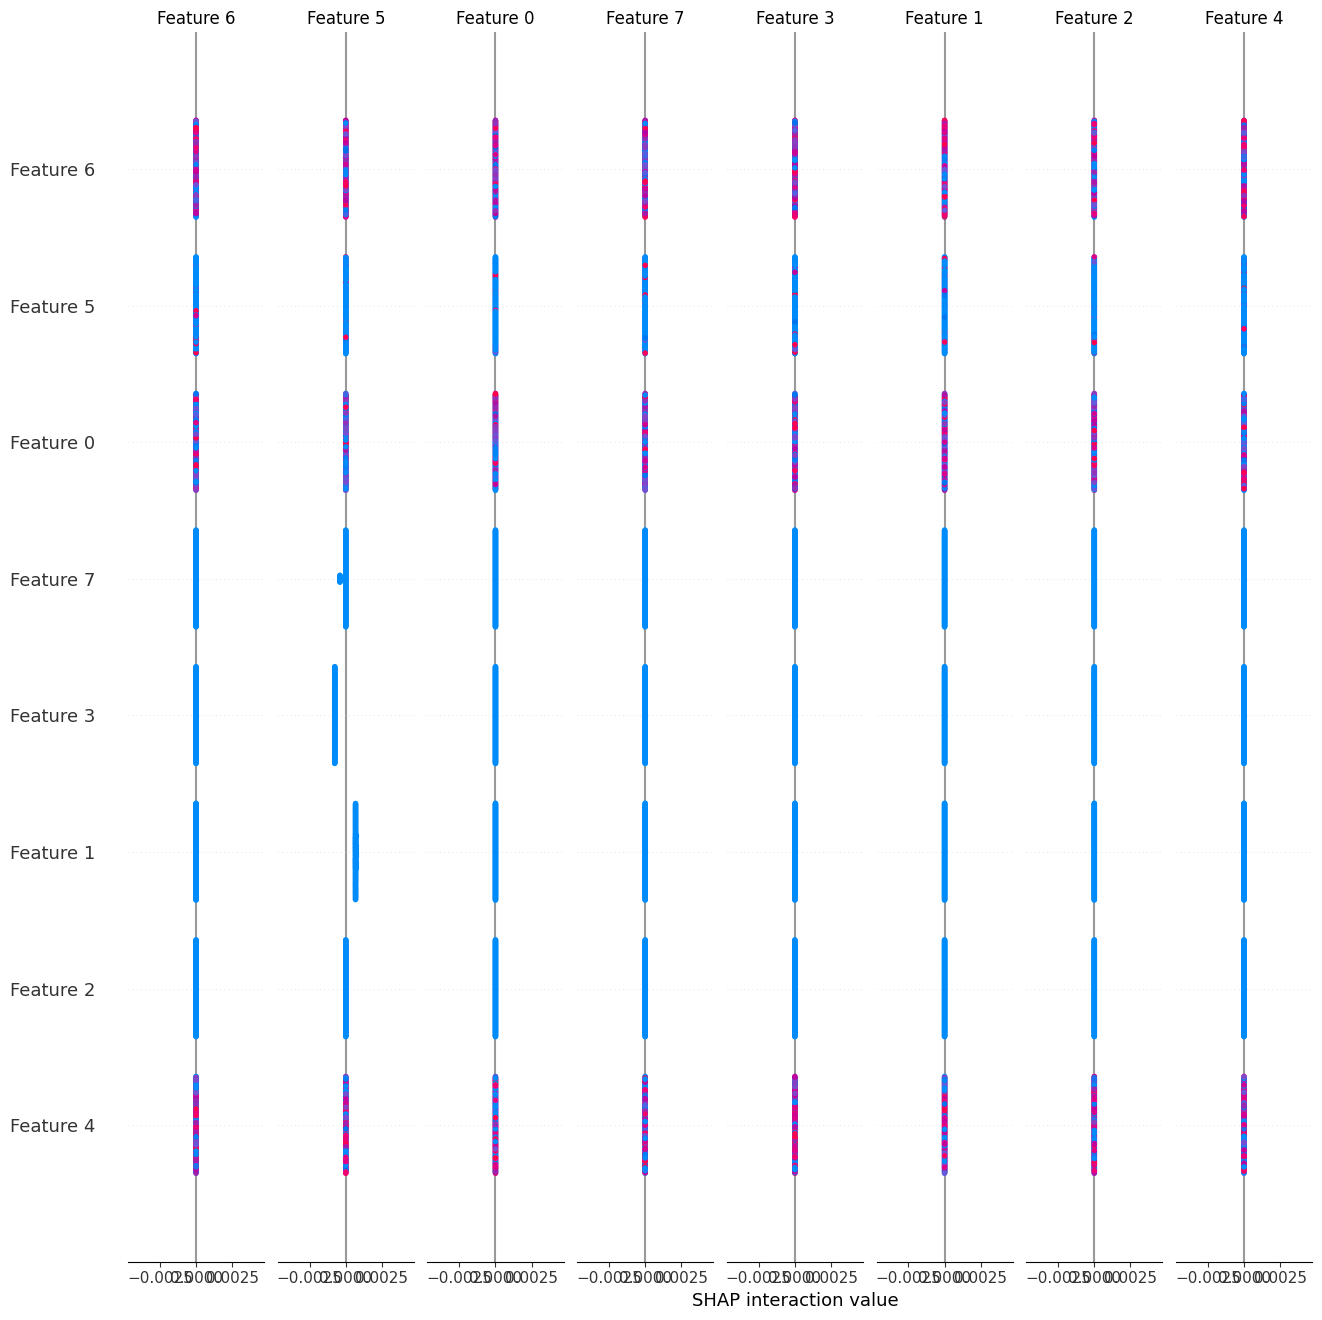

In [17]:
#AdaBoost : Beeswarm Summary Plot
print("\nAdaBoost: Beeswarm Summary Plot")
shap.summary_plot(
    shap_values_ada,
    x_test_feat,
    class_names=class_names,
    max_display=15,
    show=True
)

In [18]:
#Initialize SHAP for SVM
print("\nStarting SHAP Analysis for SVM")
explainer_svm = shap.KernelExplainer(svm.predict_proba, background_data)
shap_values_svm = explainer_svm.shap_values(x_test_feat)
print("SVM SHAP values calculated.")


Starting SHAP Analysis for SVM


100%|██████████| 184/184 [03:47<00:00,  1.24s/it]

SVM SHAP values calculated.



SVM: Global Feature Importance Plot


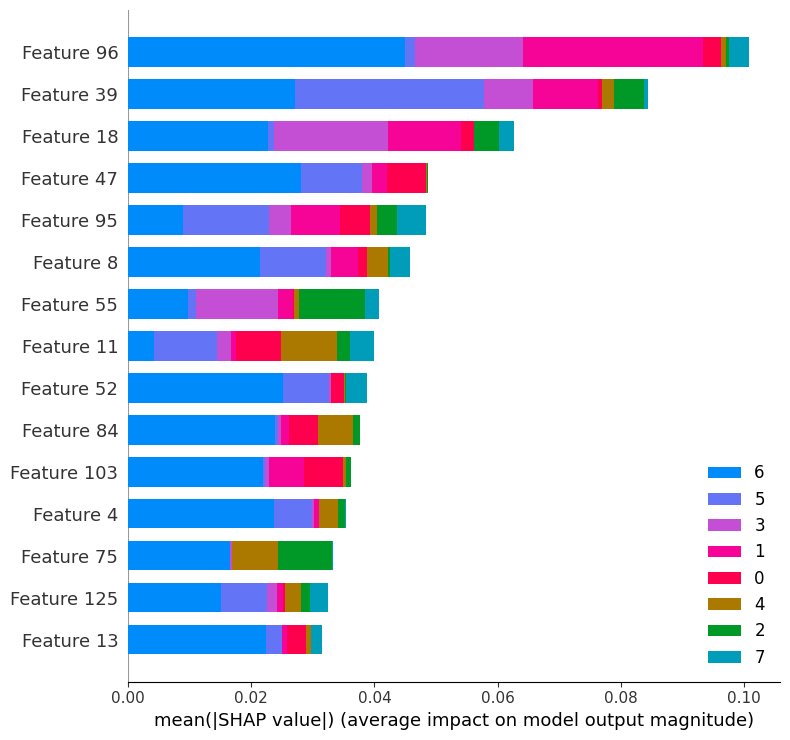

In [19]:
#SVM : Global Feature Importance (Bar Plot)
print("\nSVM: Global Feature Importance Plot")
shap.summary_plot(
    shap_values_svm,
    features=x_test_feat,
    plot_type="bar",
    class_names=class_names,
    max_display=15,
    show=True
)


SVM: Local Explanation for a Single Prediction
Explaining Instance 0:
  - True Emotion: 6 (6)
  - Predicted Emotion: 6 (6)


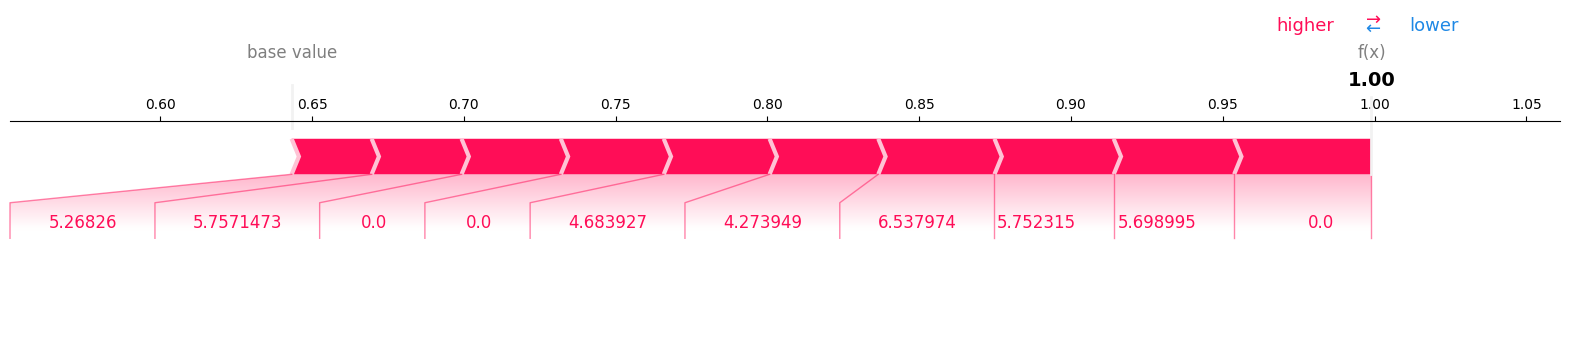

In [20]:
# SVM - Local Explanation (Force Plot)
print("\nSVM: Local Explanation for a Single Prediction")
instance_index = 0 
true_label = y_test_labels[instance_index]
predicted_label_val = svm.predict(x_test_feat[instance_index:instance_index+1])[0]

print(f"Explaining Instance {instance_index}:")
print(f"  - True Emotion: {true_label} ({class_names[true_label]})")
print(f"  - Predicted Emotion: {predicted_label_val} ({class_names[predicted_label_val]})")

shap_values_for_plot_svm = shap_values_svm[instance_index, :, true_label]

shap.force_plot(
    explainer_svm.expected_value[true_label],
    shap_values_for_plot_svm, 
    x_test_feat[instance_index, :],
    matplotlib=True,
    show=True
)


SVM: Beeswarm Summary Plot


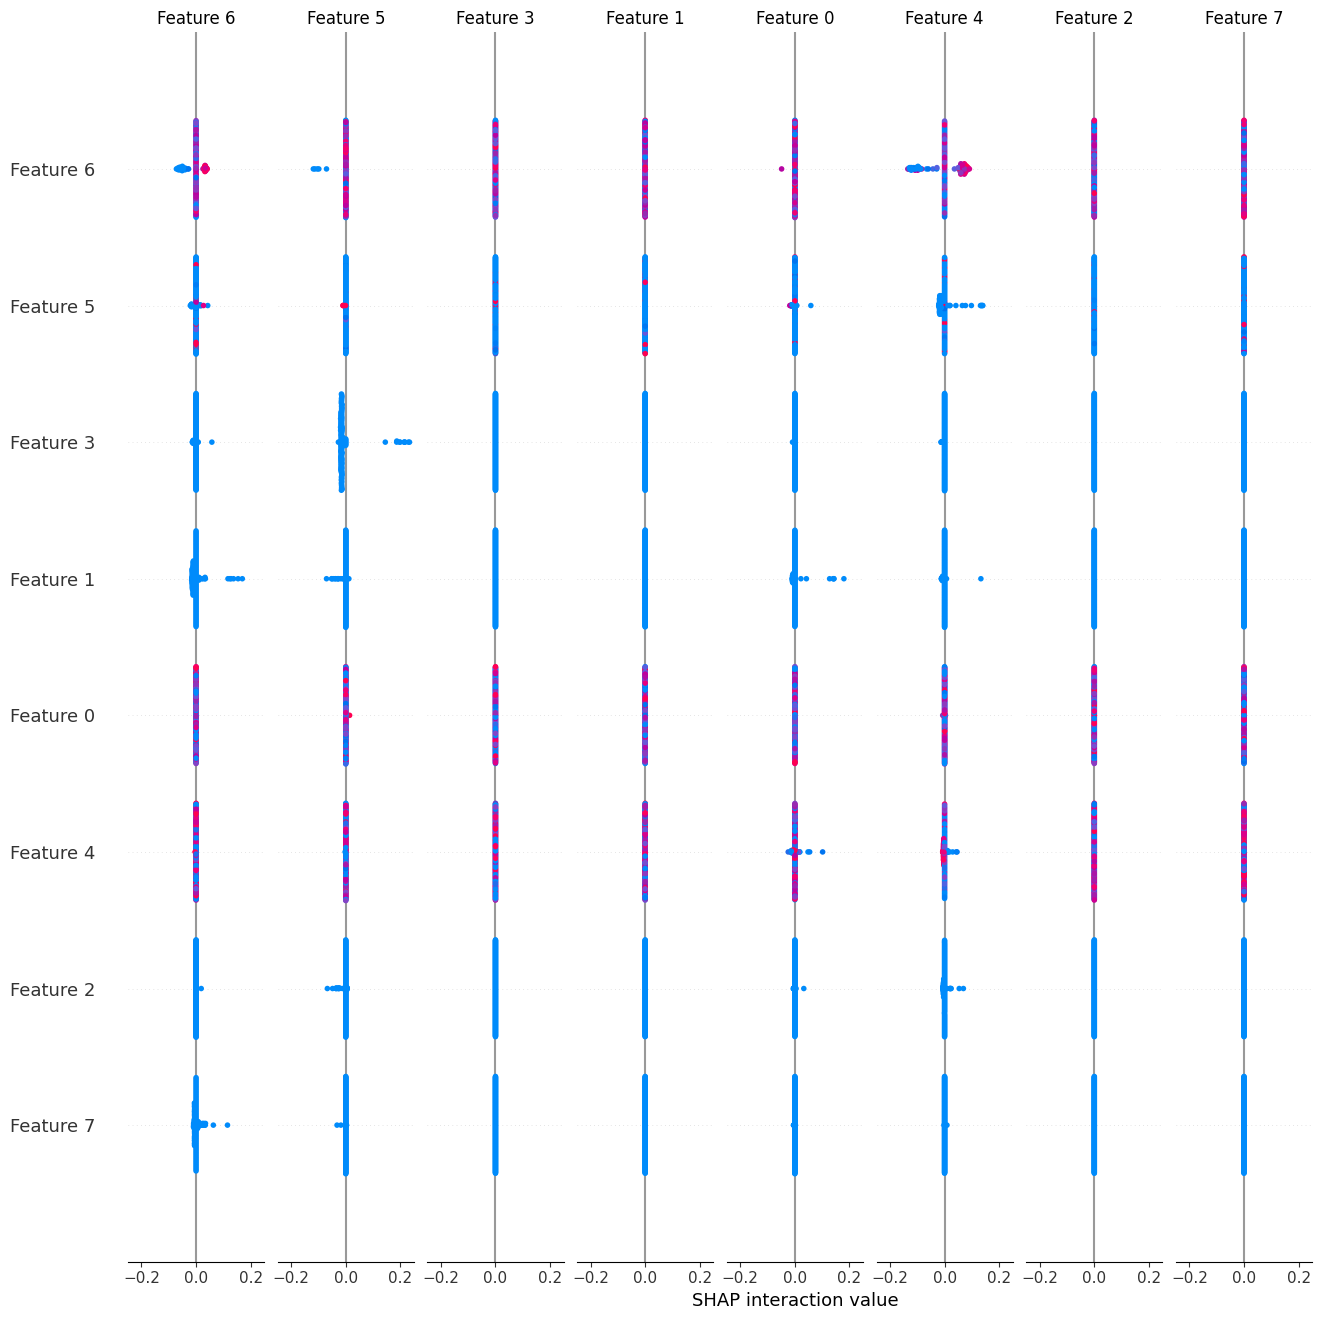

In [21]:
#SVM - Beeswarm Summary Plot
print("\nSVM: Beeswarm Summary Plot")
shap.summary_plot(
    shap_values_svm,
    x_test_feat,
    class_names=class_names,
    max_display=15,
    show=True
)

In [22]:
import joblib

cnn_model.save_weights('emotion_cnn.weights.h5')
joblib.dump(ada, 'adaboost_emotion_classifier.pkl')
joblib.dump(svm, 'svm_emotion_classifier.pkl')
print("All Saved.")

All Saved.
